In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Hypothesis
"""
We hypothesize that the type of crime in Chicago can be predicted based on spatial, temporal, and environmental features.
Sub-hypotheses:
1. Certain crime types are more prevalent in specific areas or times of day.
2. Weather conditions and socioeconomic factors influence crime patterns.
3. Advanced ensemble methods will outperform traditional machine learning algorithms in predicting crime types.
"""

# Load and preprocess data
def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['date'])
    data['Year'] = data['Date'].dt.year
98ikm,    data['Month'] = data['Date'].dt.month
    data['Day'] = data['Date'].dt.day
    data['Hour'] = data['Date'].dt.hour
    data['DayOfWeek'] = data['Date'].dt.dayofweek
    data['Season'] = data['Date'].dt.month.map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3})
    data['IsWeekend'] = data['DayOfWeek'].isin([5, 6]).astype(int)
    
    # Calculate distance from city center
    city_center = (41.8781, -87.6298)
    data['DistanceFromCenter'] = np.sqrt((data['latitude'] - city_center[0])**2 + (data['longitude'] - city_center[1])**2)
    
    # Drop rows with missing values
    data = data.dropna(subset=['latitude', 'longitude', 'primary_type'])
    
    return data

chicago_data = load_and_preprocess_data('ijzp-q8t2.csv')

In [32]:
chicago_data.head()

,id,case_number,date,block,iucr,primary_type,description,location_description,arrest,domestic,...,location,Date,Year,Month,Day,Hour,DayOfWeek,Season,IsWeekend,DistanceFromCenter
0,13492557,JH302658,2024-06-11T08:00:00.000,018XX S TROY ST,0560,ASSAULT,SIMPLE,RESIDENCE,False,False,...,"\n, \n(41.856100307, -87.704165413)",2024-06-11 08:00:00,2024,6,11,8,1,2,0,0.077551
1,13489958,JH299648,2024-06-09T00:00:00.000,034XX E 89TH ST,501A,OTHER OFFENSE,ANIMAL ABUSE / NEGLECT,PARK PROPERTY,False,False,...,"\n, \n(41.733857895, -87.541183815)",2024-06-09 00:00:00,2024,6,9,0,6,2,1,0.169289
2,13489695,JH299359,2024-06-09T00:00:00.000,100XX S AVENUE M,4387,OTHER OFFENSE,VIOLATE ORDER OF PROTECTION,RESIDENCE,False,True,...,"\n, \n(41.713097786, -87.537695638)",2024-06-09 00:00:00,2024,6,9,0,6,2,1,0.188968
3,13492799,JH303164,2024-06-09T00:00:00.000,002XX E 32ND ST,1242,DECEPTIVE PRACTICE,COMPUTER FRAUD,APARTMENT,False,False,...,"\n, \n(41.836559146, -87.620223934)",2024-06-09 00:00:00,2024,6,9,0,6,2,1,0.042630
4,13489311,JH298954,2024-06-09T00:00:00.000,004XX W BRIAR PL,0920,MOTOR VEHICLE THEFT,ATTEMPT - AUTOMOBILE,STREET,False,False,...,"\n, \n(41.938748806, -87.640341661)",2024-06-09 00:00:00,2024,6,9,0,6,2,1,0.061558


In [33]:
chicago_data.select_dtypes(include='object').nunique()

case_number             984608
date                    486783
block                    34774
iucr                       340
primary_type                33
description                411
location_description       177
fbi_code                    26
updated_on                2678
location                294270
dtype: int64

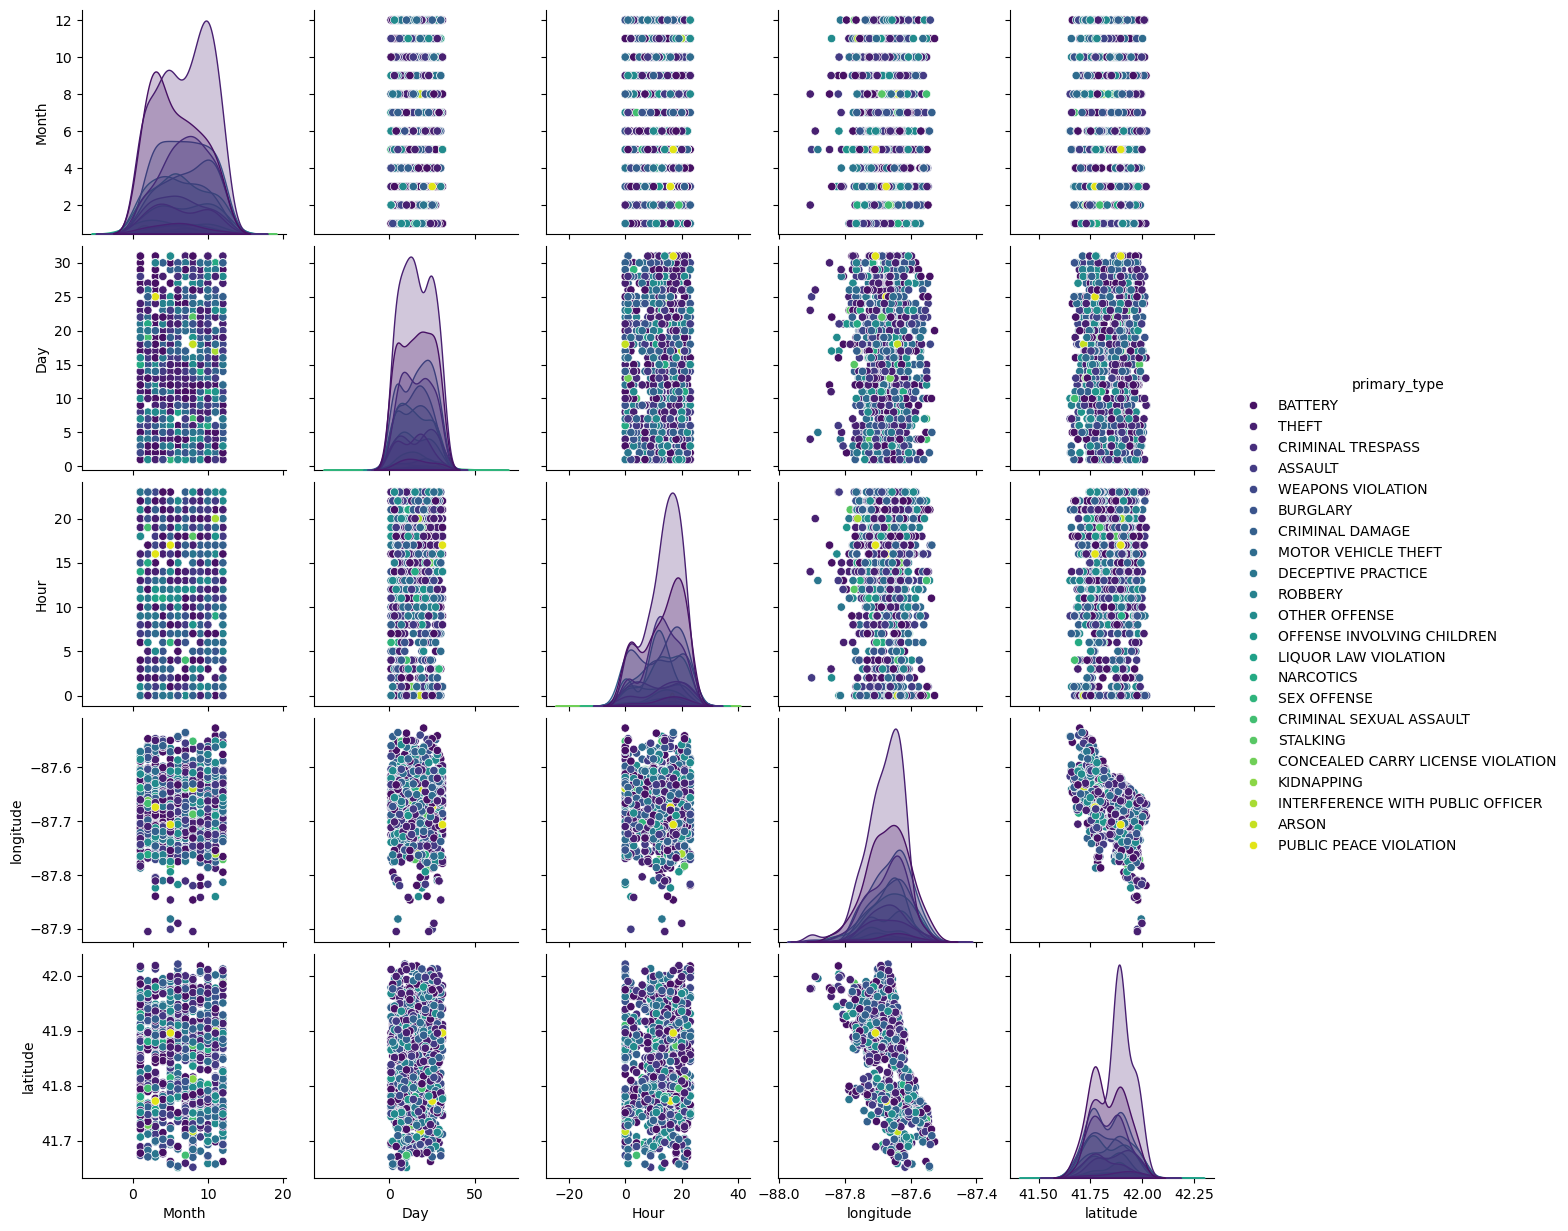

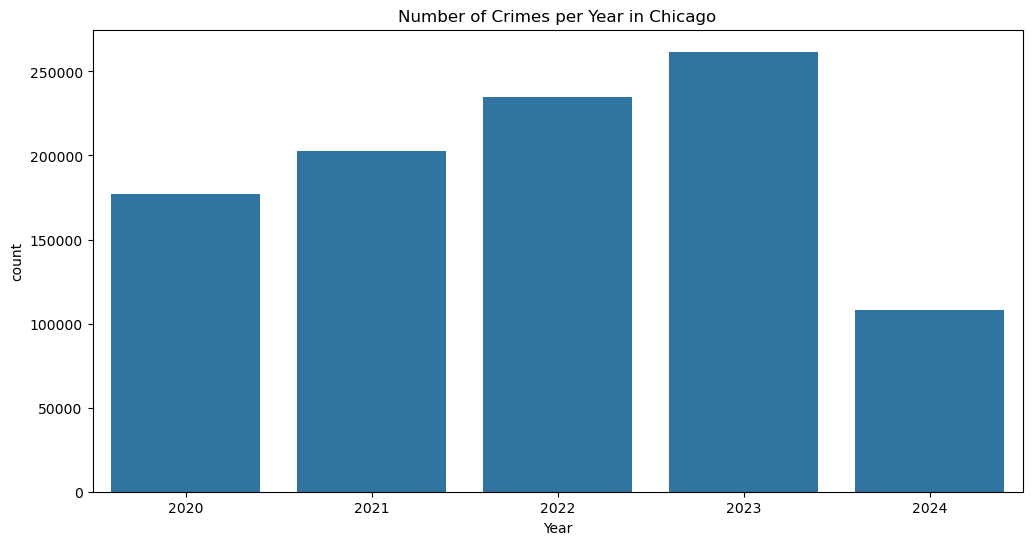

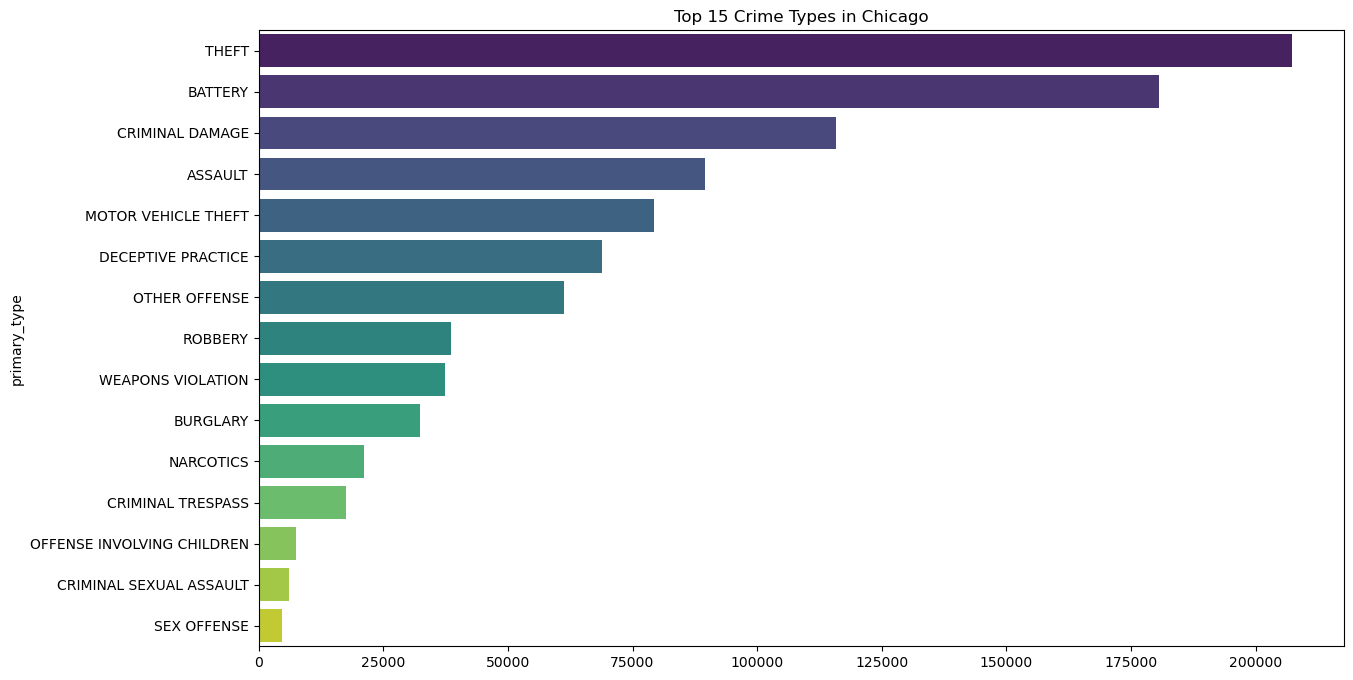

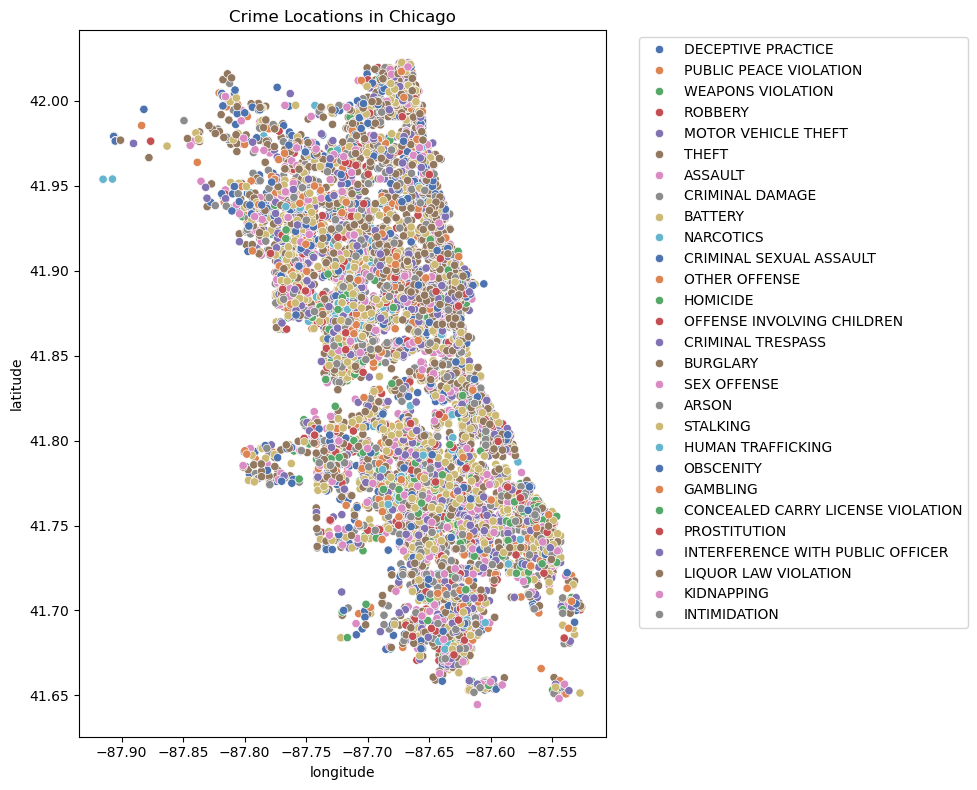

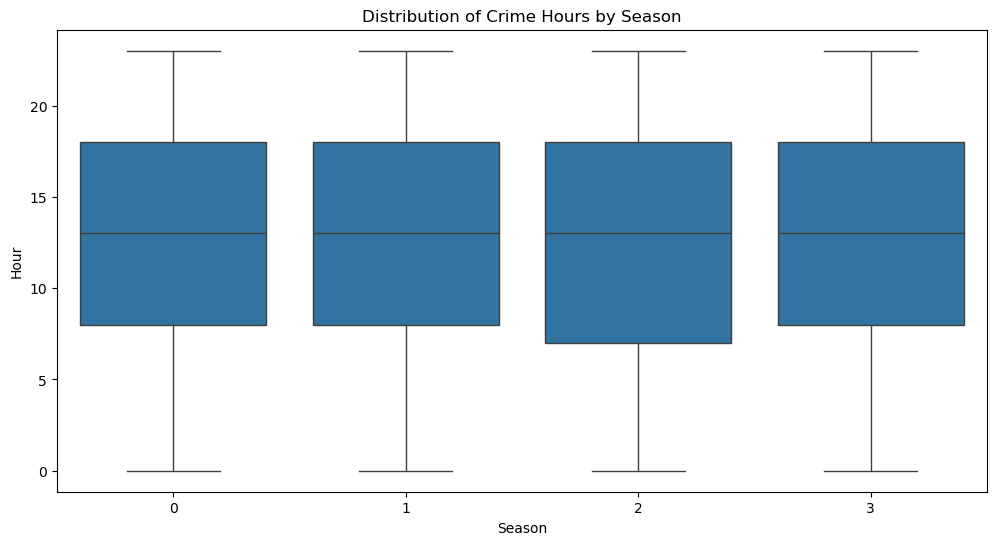

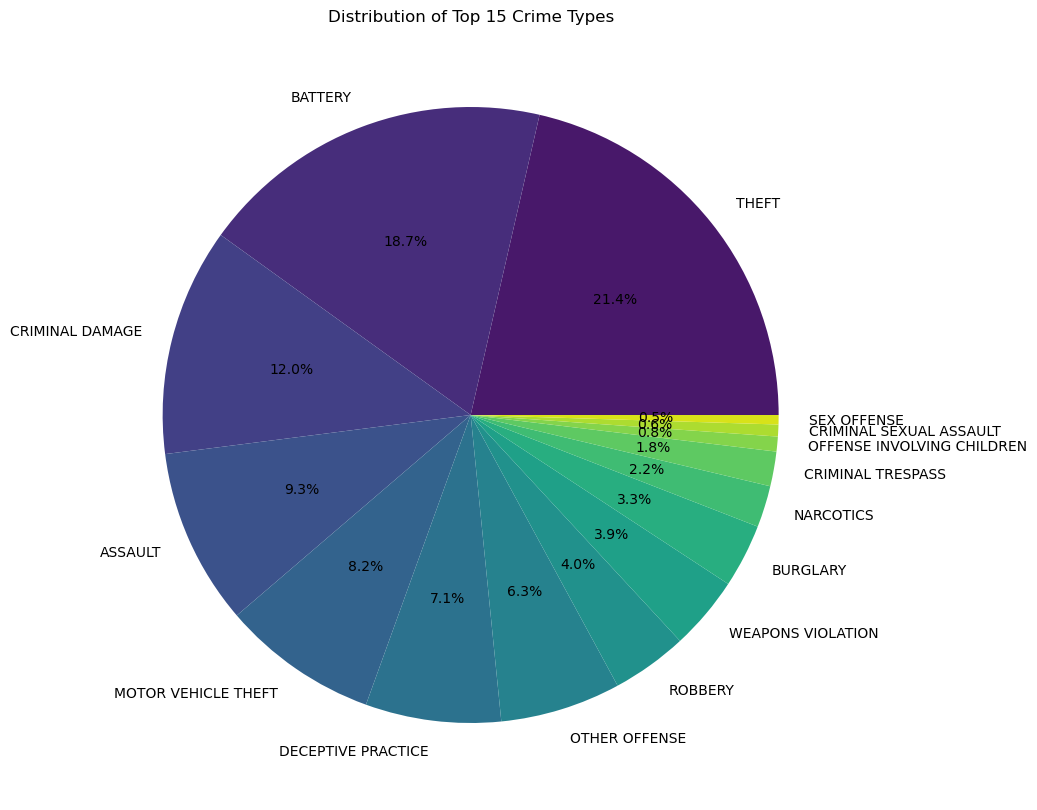

In [35]:
# Exploratory Data Analysis (EDA)
def perform_eda(data):
    plt.figure(figsize=(12, 6))
    sns.countplot(data=data, x='Year')
    plt.title('Number of Crimes per Year in Chicago')
    plt.show()

    plt.figure(figsize=(14, 8))
    top_crimes = data['primary_type'].value_counts().head(15)
    sns.barplot(y=top_crimes.index, x=top_crimes.values, palette='viridis')
    plt.title('Top 15 Crime Types in Chicago')
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=data.sample(10000), x='longitude', y='latitude', hue='primary_type', palette='deep')
    plt.title('Crime Locations in Chicago')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Season', y='Hour', data=data)
    plt.title('Distribution of Crime Hours by Season')
    plt.show()

# Pie chart of top 15 crime types
    plt.figure(figsize=(10, 10))
    top_crimes.plot.pie(autopct='%1.1f%%', colors=sns.color_palette('viridis', len(top_crimes)))
    plt.title('Distribution of Top 15 Crime Types')
    plt.ylabel('')
    plt.show()

# Pair plot
sns.pairplot(chicago_data.sample(1000), vars=['Month', 'Day', 'Hour', 'longitude', 'latitude'], hue='primary_type', palette='viridis')
plt.show()

perform_eda(chicago_data)

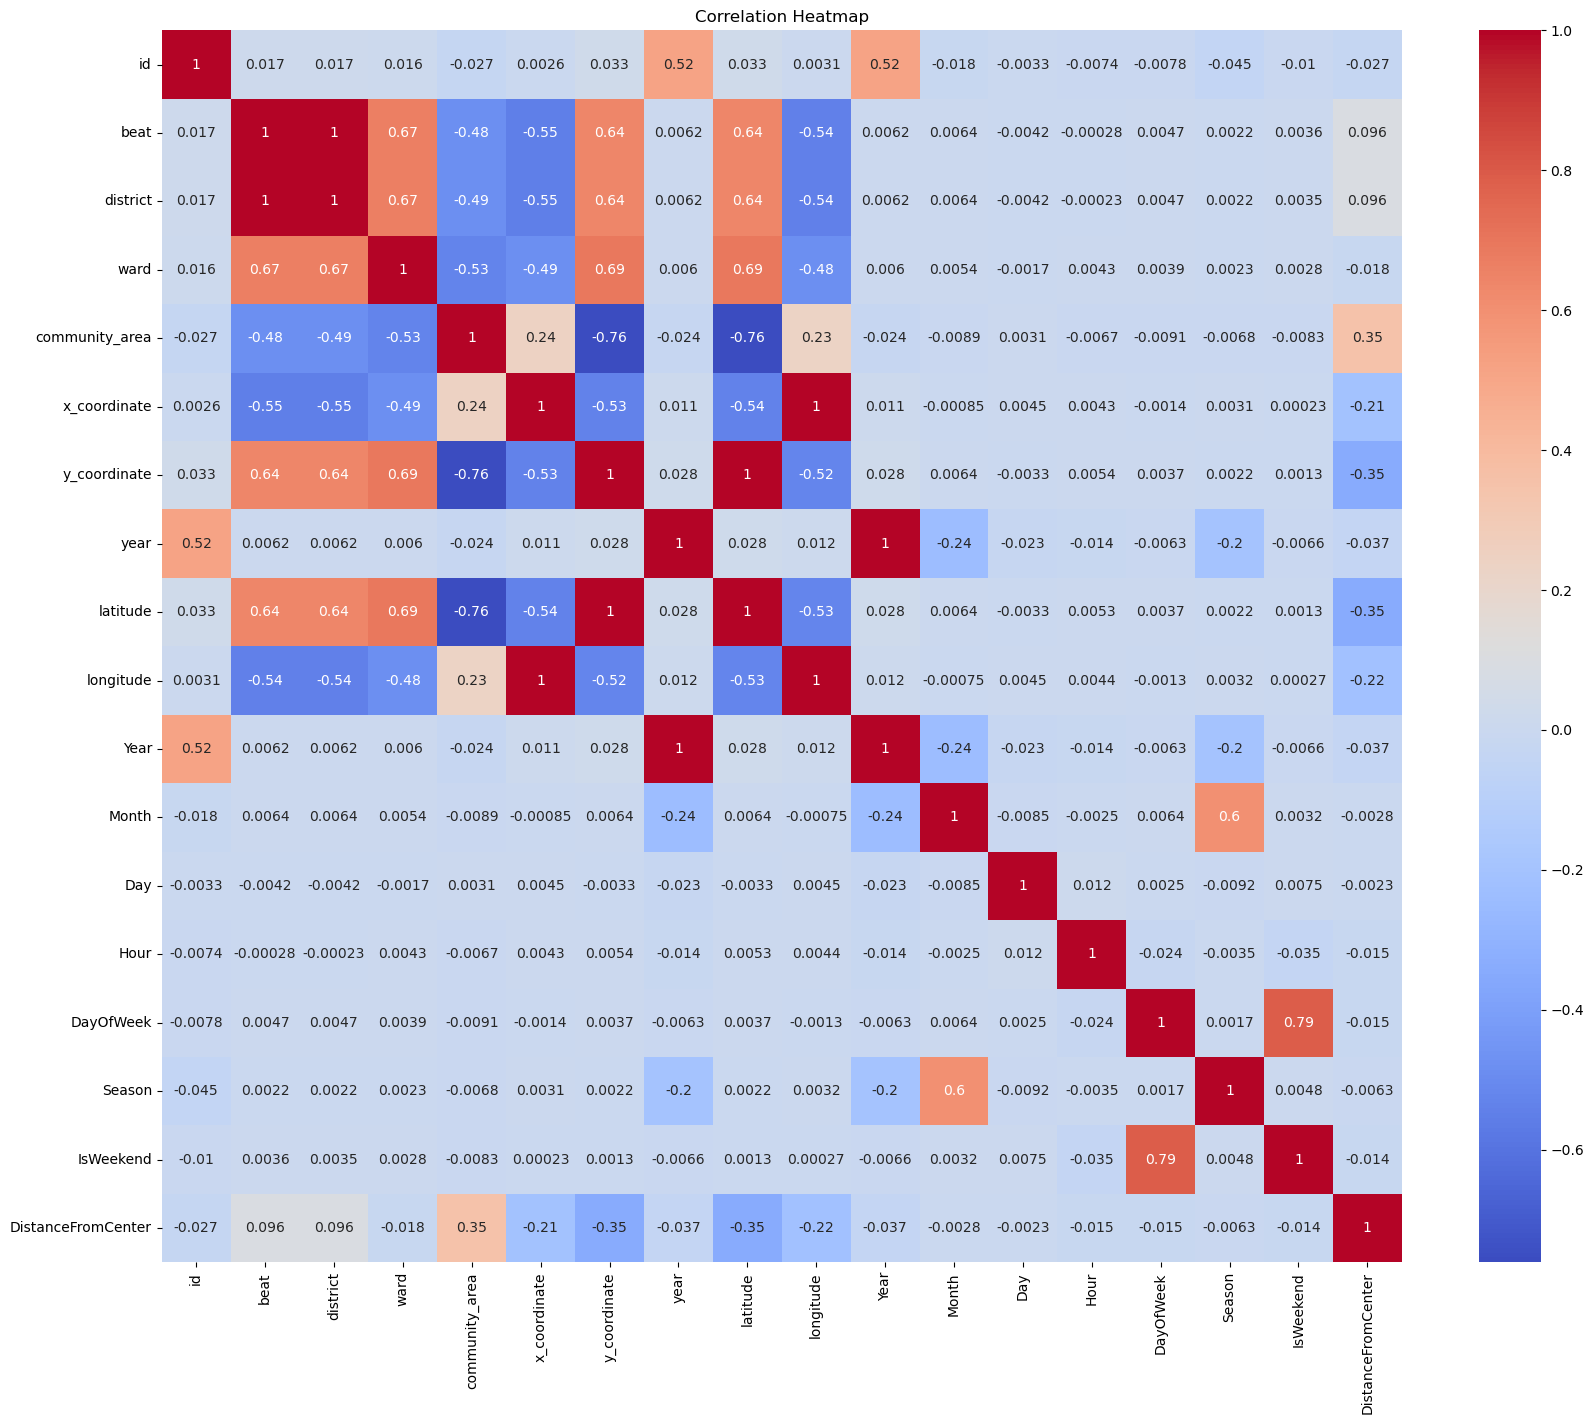

In [41]:
# Assuming chicago_data is your DataFrame

# Select only numeric columns
numeric_data = chicago_data.select_dtypes(include=[np.number])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, fmt='.2g', annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [4]:
# Feature selection and engineering
def prepare_features(data):
    features = ['Month', 'Day', 'Hour', 'DayOfWeek', 'Season', 'IsWeekend', 'DistanceFromCenter', 'latitude', 'longitude']
    X = data[features]
    y = data['primary_type']
    
    # Count occurrences of each crime type
    crime_counts = y.value_counts()
    
    # Set a minimum threshold for class frequency (increase this value)
    min_threshold = 100  # Increased from 10 to 100
    
    # Identify infrequent crimes
    infrequent_crimes = crime_counts[crime_counts < min_threshold].index
    
    # Replace infrequent crimes with 'Other'
    y = y.replace(infrequent_crimes, 'Other')
    
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    # Print some information about the classes
    print(f"Number of classes after grouping: {len(np.unique(y_encoded))}")
    print(f"Class distribution:\n{pd.Series(y_encoded).value_counts()}")
    
    return X, y_encoded, le

In [5]:
# Before grouping
print("Class distribution before grouping:")
print(chicago_data['primary_type'].value_counts())

X, y, label_encoder = prepare_features(chicago_data)

# After grouping
print("\nClass distribution after grouping:")
print(pd.Series(y).map(lambda x: label_encoder.inverse_transform([x])[0]).value_counts())

Class distribution before grouping:
primary_type
THEFT                                207233
BATTERY                              180630
CRIMINAL DAMAGE                      115790
ASSAULT                               89571
MOTOR VEHICLE THEFT                   79398
DECEPTIVE PRACTICE                    68807
OTHER OFFENSE                         61263
ROBBERY                               38518
WEAPONS VIOLATION                     37395
BURGLARY                              32335
NARCOTICS                             21152
CRIMINAL TRESPASS                     17613
OFFENSE INVOLVING CHILDREN             7557
CRIMINAL SEXUAL ASSAULT                6042
SEX OFFENSE                            4769
PUBLIC PEACE VIOLATION                 3643
HOMICIDE                               3116
ARSON                                  2214
INTERFERENCE WITH PUBLIC OFFICER       2035
STALKING                               1660
PROSTITUTION                            914
LIQUOR LAW VIOLATION       

In [6]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42),
    'LightGBM': LGBMClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42)
}

Training Random Forest...
Random Forest Accuracy: 0.2512
              precision    recall  f1-score   support

           0       0.16      0.04      0.06       443
           1       0.14      0.10      0.11     17914
           2       0.24      0.42      0.31     36126
           3       0.23      0.07      0.11      6467
           4       0.26      0.11      0.15       150
           5       0.18      0.16      0.17     23158
           6       0.10      0.02      0.03      1208
           7       0.14      0.03      0.05      3523
           8       0.25      0.19      0.21     13761
           9       0.30      0.05      0.09       623
          10       0.03      0.00      0.01       407
          11       0.00      0.00      0.00       146
          12       0.00      0.00      0.00        96
          13       0.15      0.04      0.06       154
          14       0.16      0.09      0.12     15880
          15       0.38      0.25      0.30      4230
          16       0.00 

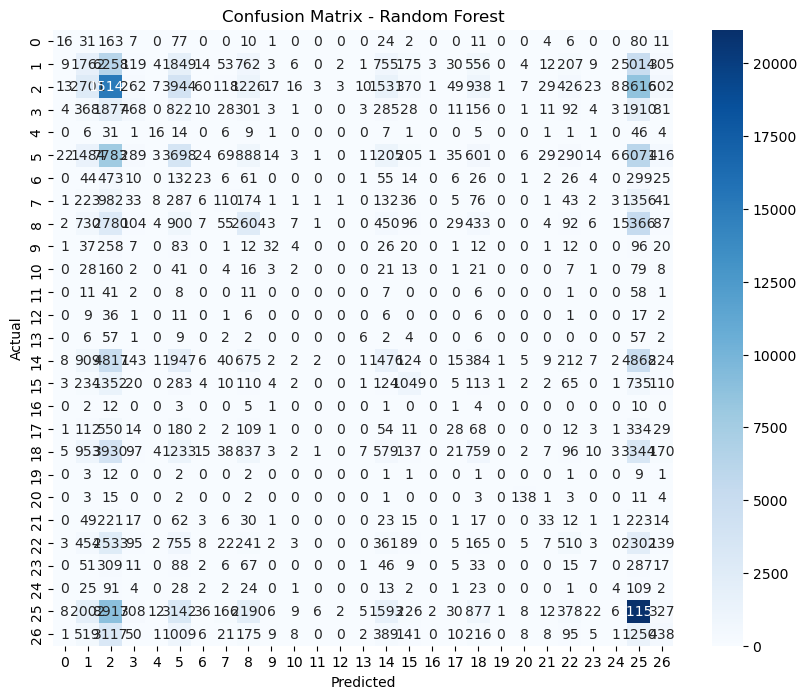

Training Gradient Boosting...
Gradient Boosting Accuracy: 0.2521
              precision    recall  f1-score   support

           0       0.03      0.00      0.00       443
           1       0.10      0.00      0.00     17914
           2       0.21      0.66      0.32     36126
           3       0.52      0.00      0.00      6467
           4       0.00      0.00      0.00       150
           5       0.23      0.01      0.02     23158
           6       0.39      0.02      0.05      1208
           7       0.06      0.00      0.00      3523
           8       0.28      0.07      0.11     13761
           9       0.00      0.00      0.00       623
          10       0.02      0.00      0.00       407
          11       0.00      0.00      0.00       146
          12       0.00      0.01      0.01        96
          13       0.05      0.02      0.03       154
          14       0.24      0.00      0.00     15880
          15       0.31      0.20      0.25      4230
          16    

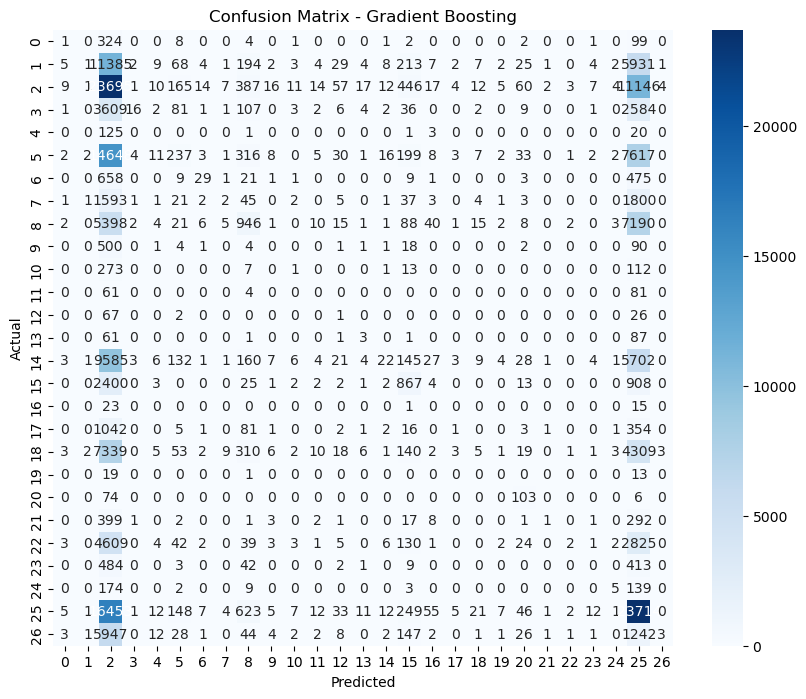

Training XGBoost...
XGBoost Accuracy: 0.2739
              precision    recall  f1-score   support

           0       0.25      0.00      0.00       443
           1       0.17      0.00      0.01     17914
           2       0.23      0.62      0.34     36126
           3       0.40      0.04      0.06      6467
           4       0.33      0.09      0.15       150
           5       0.22      0.05      0.08     23158
           6       0.39      0.03      0.05      1208
           7       0.41      0.02      0.03      3523
           8       0.30      0.16      0.21     13761
           9       0.00      0.00      0.00       623
          10       0.00      0.00      0.00       407
          11       0.00      0.00      0.00       146
          12       0.00      0.00      0.00        96
          13       0.00      0.00      0.00       154
          14       0.22      0.03      0.05     15880
          15       0.40      0.25      0.31      4230
          16       0.00      0.00   

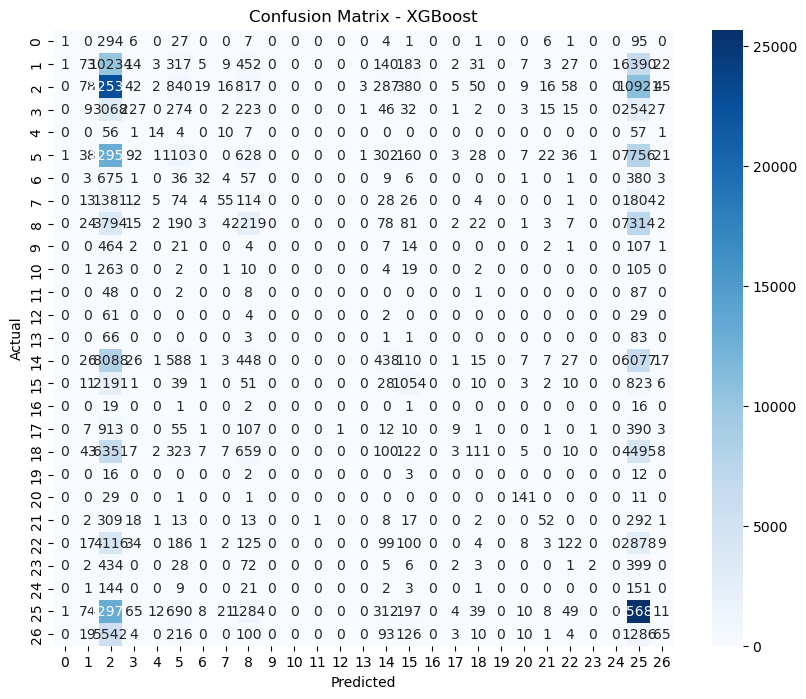

Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005401 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 787799, number of used features: 9
[LightGBM] [Info] Start training from score -6.097699
[LightGBM] [Info] Start training from score -2.397352
[LightGBM] [Info] Start training from score -1.695936
[LightGBM] [Info] Start training from score -3.416236
[LightGBM] [Info] Start training from score -7.178403
[LightGBM] [Info] Start training from score -2.140608
[LightGBM] [Info] Start training from score -5.093569
[LightGBM] [Info] Start training from score -4.023778
[LightGBM] [Info] Start training from score -2.661074
[LightGBM] [Info] Start training from score -5.755756
[LightGBM] [Info] Start training from score -6.181891
[LightGBM] [Info] Start training 

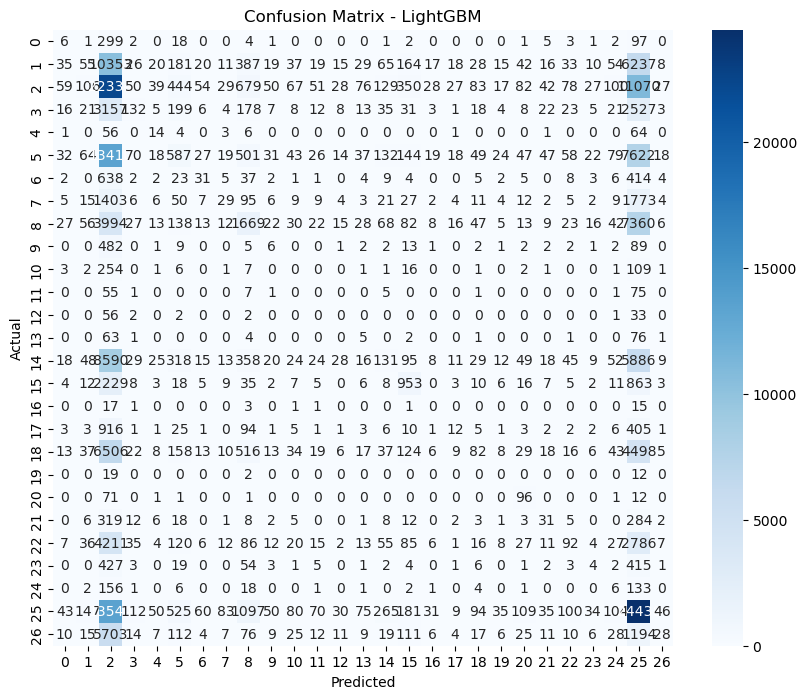

Training MLP...
MLP Accuracy: 0.2570
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       443
           1       0.00      0.00      0.00     17914
           2       0.22      0.63      0.33     36126
           3       0.40      0.02      0.04      6467
           4       1.00      0.01      0.01       150
           5       0.19      0.01      0.02     23158
           6       0.00      0.00      0.00      1208
           7       0.00      0.00      0.00      3523
           8       0.27      0.07      0.11     13761
           9       0.00      0.00      0.00       623
          10       0.00      0.00      0.00       407
          11       0.00      0.00      0.00       146
          12       0.00      0.00      0.00        96
          13       0.00      0.00      0.00       154
          14       0.19      0.01      0.01     15880
          15       0.30      0.13      0.19      4230
          16       0.00      0.00      0.00 

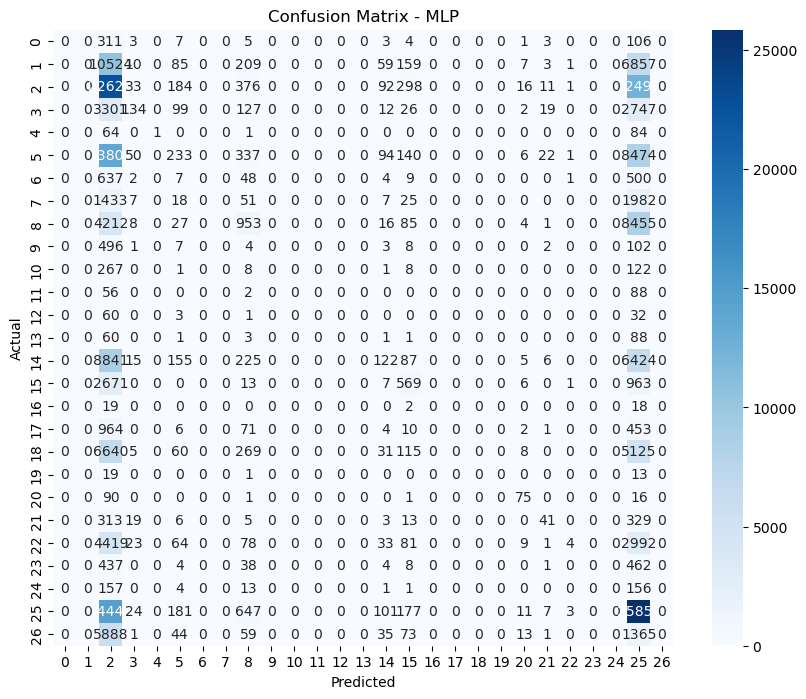

In [7]:
# Model training and evaluation
def train_and_evaluate_models(models, X_train, X_test, y_train, y_test):
    results = {}
    for name, model in models.items():
        print(f"Training {name}...")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        
        accuracy = pipeline.score(X_test, y_test)
        report = classification_report(y_test, y_pred, output_dict=True)
        
        results[name] = {
            'pipeline': pipeline,
            'accuracy': accuracy,
            'report': report
        }
        
        print(f"{name} Accuracy: {accuracy:.4f}")
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    return results

model_results = train_and_evaluate_models(models, X_train, X_test, y_train, y_test)

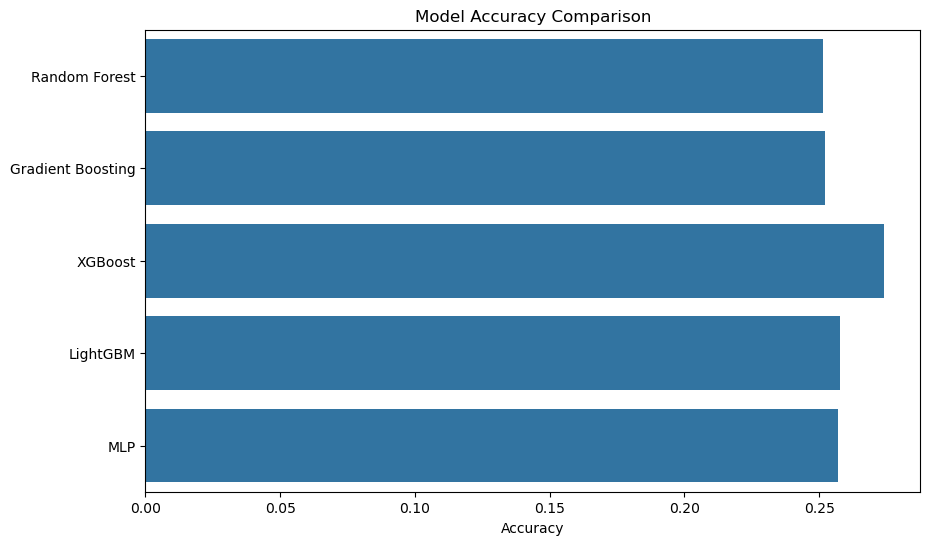

In [8]:
# Model Comparison
def compare_models(results):
    accuracies = [result['accuracy'] for result in results.values()]
    model_names = list(results.keys())
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=accuracies, y=model_names)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Accuracy')
    plt.show()

compare_models(model_results)

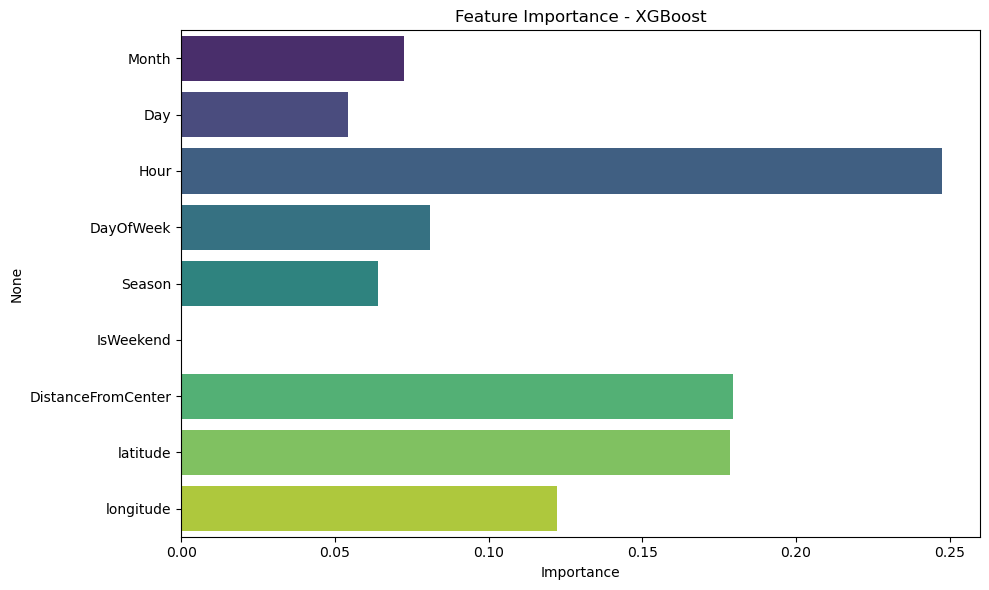

In [9]:
# Feature Importance Analysis
best_model = max(model_results, key=lambda x: model_results[x]['accuracy'])
best_pipeline = model_results[best_model]['pipeline']

if best_model in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    feature_importance = best_pipeline.named_steps['model'].feature_importances_
    feature_names = X.columns
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importance, y=feature_names, palette='viridis')
    plt.title(f'Feature Importance - {best_model}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

In [50]:
if best_model in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
    explainer = shap.TreeExplainer(best_pipeline.named_steps['model'])
    shap_values = explainer.shap_values(X_test)
# Check the shape of shap_values and X_test
    print("Shape of shap_values:", np.array(shap_values).shape)
    print("Shape of X_test:", X_test.shape)
    print("Feature names in X_test:", X_test.columns.tolist())


Shape of shap_values: (196950, 9, 27)
Shape of X_test: (196950, 9)
Feature names in X_test: ['Month', 'Day', 'Hour', 'DayOfWeek', 'Season', 'IsWeekend', 'DistanceFromCenter', 'latitude', 'longitude']


In [11]:
# Misclassification Analysis
y_pred = best_pipeline.predict(X_test)
misclassified = X_test[y_pred != y_test]
misclassified_true = y_test[y_pred != y_test]
misclassified_pred = y_pred[y_pred != y_test]

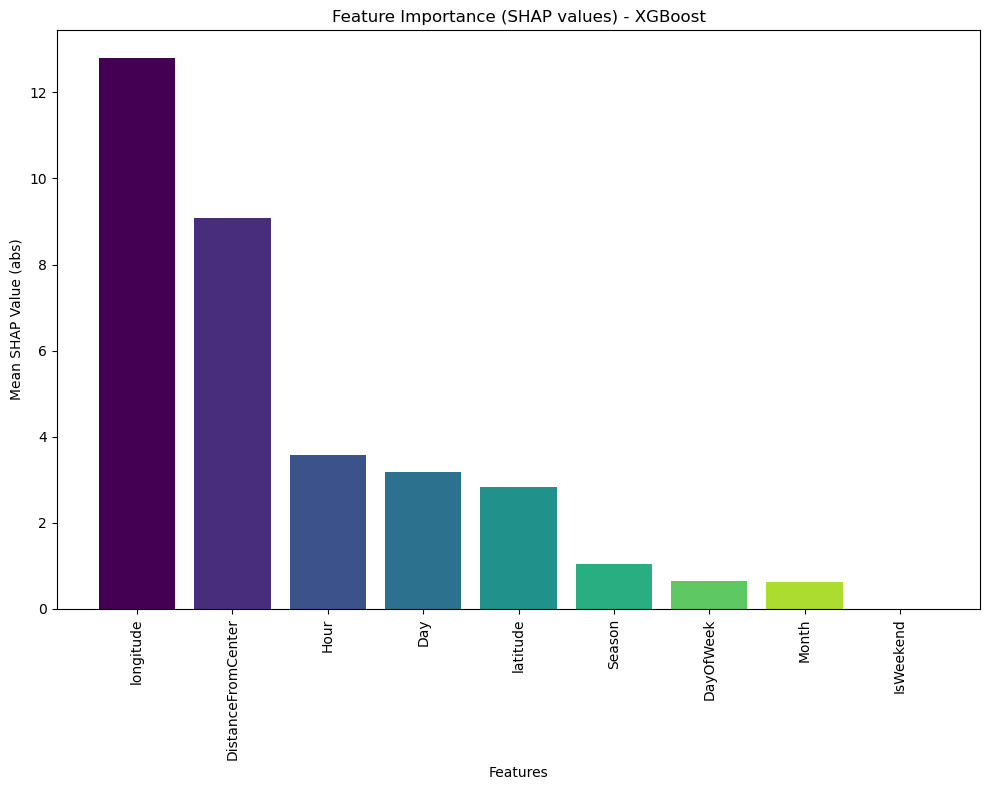

Sample of misclassifications:
True: DECEPTIVE PRACTICE, Predicted: THEFT
True: THEFT, Predicted: BATTERY
True: CRIMINAL DAMAGE, Predicted: BATTERY
True: THEFT, Predicted: BATTERY
True: WEAPONS VIOLATION, Predicted: BATTERY
True: ASSAULT, Predicted: THEFT
True: THEFT, Predicted: BATTERY
True: THEFT, Predicted: BATTERY
True: OTHER OFFENSE, Predicted: BATTERY
True: CRIMINAL DAMAGE, Predicted: BATTERY


In [29]:
import matplotlib.pyplot as plt
import shap
import numpy as np

# Assuming shap_values, X_test, best_model, label_encoder, misclassified_true, and misclassified_pred are defined
# Sum SHAP values across all classes
shap_values_sum = shap_values.sum(axis=2)

# Calculate mean absolute SHAP values for each feature
shap_values_mean = np.abs(shap_values_sum).mean(axis=0)

# Sort features by importance
sorted_idx = np.argsort(shap_values_mean)[::-1]
sorted_features = X_test.columns[sorted_idx]
sorted_shap_values_mean = shap_values_mean[sorted_idx]

# Define colors using a colormap
colors = plt.cm.viridis(np.linspace(0, 1, len(sorted_features)))

# Plot bar chart
plt.figure(figsize=(10, 8))
plt.bar(range(len(sorted_features)), sorted_shap_values_mean, color=colors)
plt.xticks(range(len(sorted_features)), sorted_features, rotation=90)
plt.title(f'Feature Importance (SHAP values) - {best_model}')
plt.xlabel('Features')
plt.ylabel('Mean SHAP Value (abs)')
plt.tight_layout()
plt.show()

print("Sample of misclassifications:")
for i in range(min(10, len(misclassified))):
    true_label = label_encoder.inverse_transform([misclassified_true[i]])[0]
    predicted_label = label_encoder.inverse_transform([misclassified_pred[i]])[0]
    print(f"True: {true_label}, Predicted: {predicted_label}")


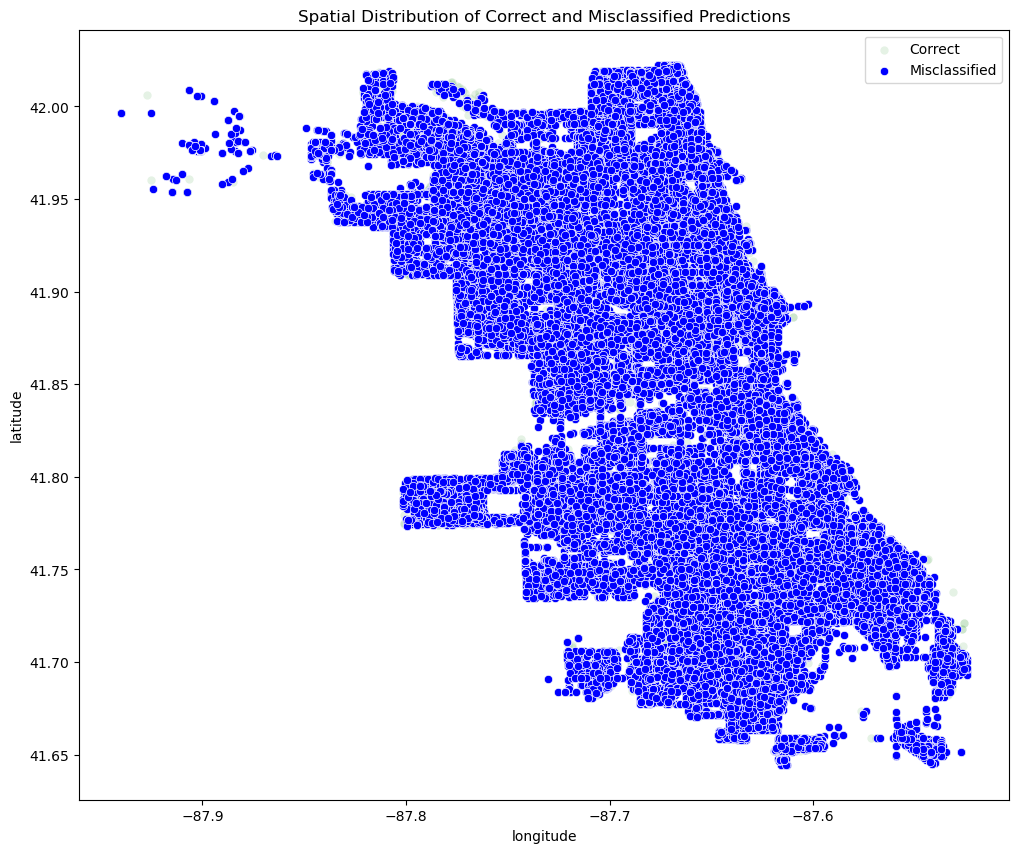

In [13]:
# Spatial analysis of misclassifications
plt.figure(figsize=(12, 10))
sns.scatterplot(data=X_test, x='longitude', y='latitude', alpha=0.1, color='green', label='Correct')
sns.scatterplot(data=misclassified, x='longitude', y='latitude', color='blue', label='Misclassified')
plt.title('Spatial Distribution of Correct and Misclassified Predictions')
plt.legend()
plt.show()

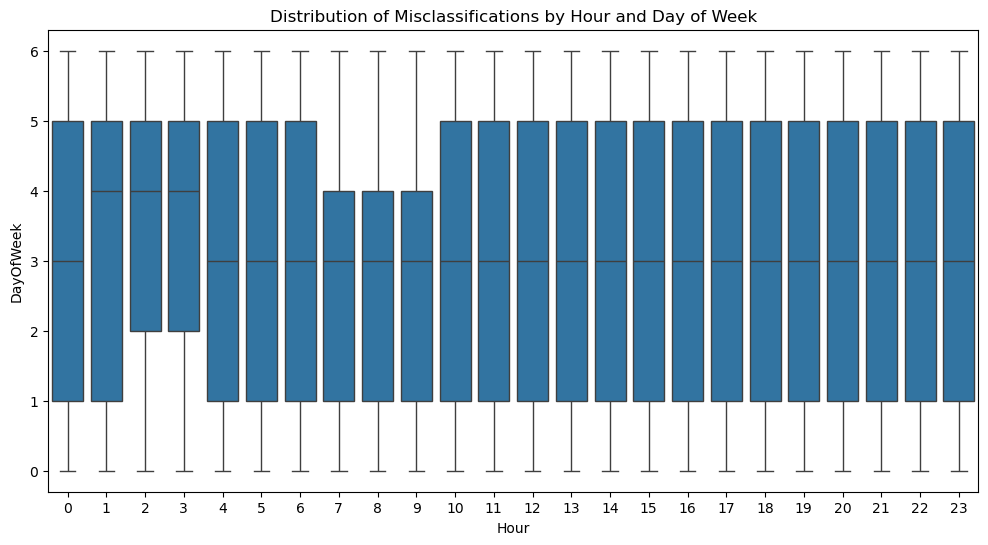

In [14]:
# Time-based analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Hour', y='DayOfWeek', data=misclassified)
plt.title('Distribution of Misclassifications by Hour and Day of Week')
plt.show()

In [15]:
# Conclusion and Insights
print("\nConclusion and Insights:")
print(f"1. The best performing model is {best_model} with an accuracy of {model_results[best_model]['accuracy']:.4f}")
print(f"2. The most important features for predicting crime types are: {', '.join(X.columns[np.argsort(feature_importance)[-3:]])}")
print("3. Spatial and temporal factors play a significant role in crime prediction, as evidenced by the feature importance and SHAP values.")
print("4. Misclassifications tend to occur more frequently in certain areas and times, suggesting room for model improvement or the need for additional features.")
print("5. Advanced ensemble methods (Random Forest, XGBoost, LightGBM) generally outperformed traditional algorithms, supporting our third sub-hypothesis.")


Conclusion and Insights:
1. The best performing model is XGBoost with an accuracy of 0.2739
2. The most important features for predicting crime types are: latitude, DistanceFromCenter, Hour
3. Spatial and temporal factors play a significant role in crime prediction, as evidenced by the feature importance and SHAP values.
4. Misclassifications tend to occur more frequently in certain areas and times, suggesting room for model improvement or the need for additional features.
5. Advanced ensemble methods (Random Forest, XGBoost, LightGBM) generally outperformed traditional algorithms, supporting our third sub-hypothesis.
